In [1]:
import io
import numpy as np
import PIL
import requests
import openpifpaf
openpifpaf.show.Canvas.show = True
import cv2
import matplotlib.pyplot as plt

print('OpenPifPaf version', openpifpaf.__version__)

OpenPifPaf version 0.13.1


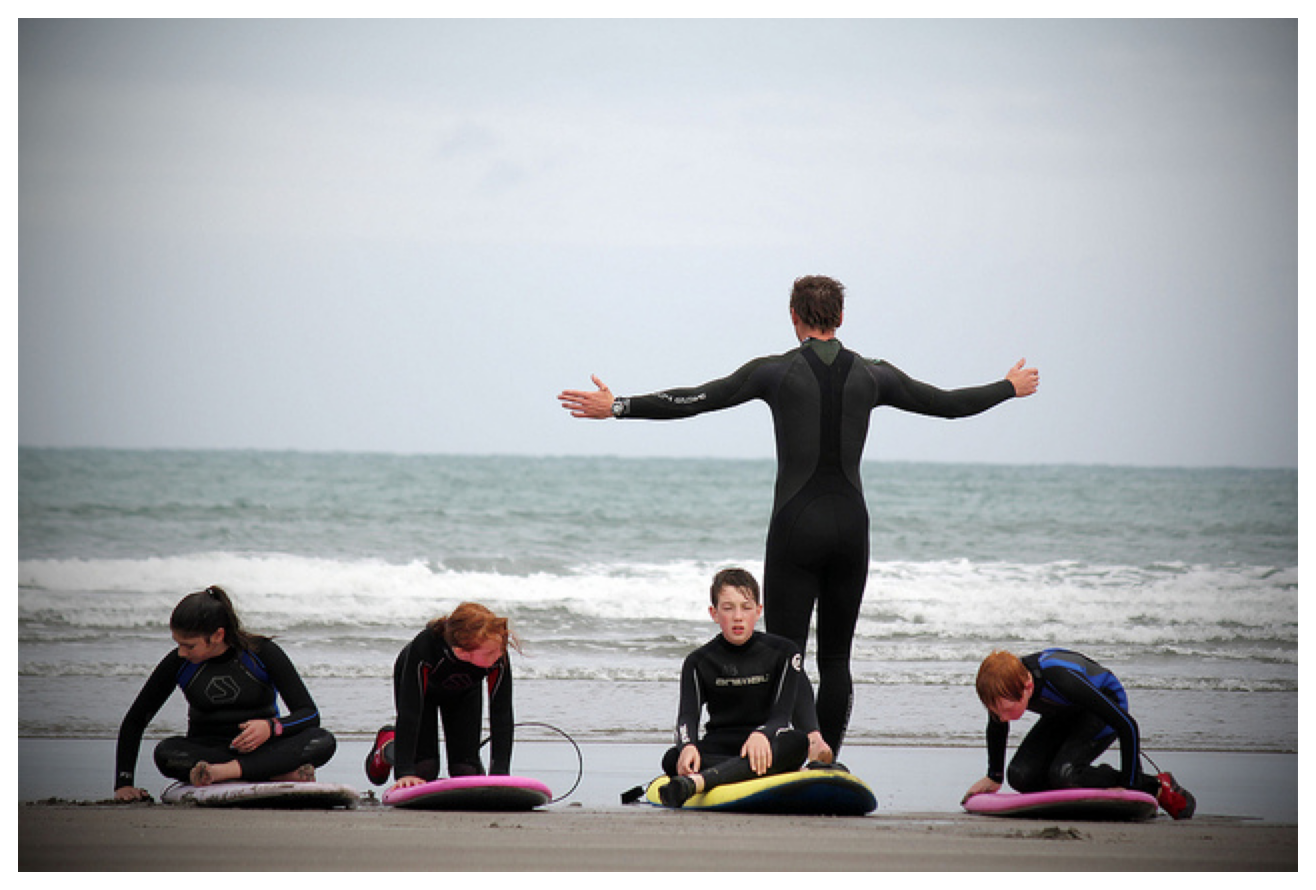

In [2]:
image_response = requests.get('https://raw.githubusercontent.com/openpifpaf/openpifpaf/main/docs/coco/000000081988.jpg')



pil_im = PIL.Image.open(io.BytesIO(image_response.content)).convert('RGB')
im = np.asarray(pil_im)

with openpifpaf.show.image_canvas(im) as ax:
    pass

In [3]:
#predictor = openpifpaf.Predictor(checkpoint='shufflenetv2k16')
predictor = openpifpaf.Predictor(checkpoint='mobilenetv3small')
predictions, gt_anns, image_meta = predictor.pil_image(pil_im)

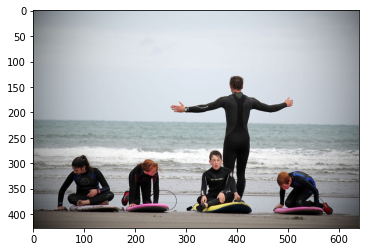

In [4]:
plt.imshow(im)

In [5]:
squelet_point = np.array(predictions[0].skeleton) - (1,1)
print(predictions[0].data[0][0:2].astype(int))
print(predictions[2].data)
print(predictions[0].joint_scales)

[ 81 317]
[[359.72357    299.71494      0.8047417 ]
 [364.11856    294.77045      0.78278476]
 [354.66324    295.3415       0.81230056]
 [369.80664    294.99878      0.7093424 ]
 [347.41653    297.15463      0.87839043]
 [381.33493    319.2304       0.80609745]
 [340.1973     323.26602      0.99803185]
 [  0.          -3.           0.        ]
 [334.57343    355.03705      0.8651968 ]
 [  0.          -3.           0.        ]
 [334.87173    364.17807      0.6440138 ]
 [376.13434    367.42276      0.7138365 ]
 [352.01895    369.7777       0.7937598 ]
 [  0.          -3.           0.        ]
 [  0.          -3.           0.        ]
 [  0.          -3.           0.        ]
 [  0.          -3.           0.        ]]
[ 3.0194516  2.9759073  2.7488172  4.04183    0.         9.835766
 10.124293   8.563898   8.711692   6.020581   6.5697975 10.75553
 11.309265   0.         0.         0.         0.       ]


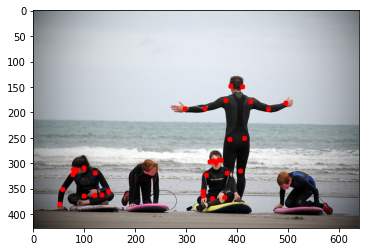

In [6]:
center_coordinates = (120, 50)
 
# Radius of circle
radius = 5

im2 = im.copy()
  
# Blue color in BGR

color = (255, 0, 0)
  
# Line thickness of 2 px
thickness = -1
for pose in predictions:
    for point in pose.data:
        if not (point[0] == 0 or point[1] == 0):
            im2 = cv2.circle(im2, point[0:2].astype(int), radius, color, thickness)

#Displaying the image
plt.imshow(im2)

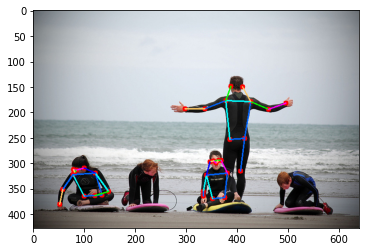

In [7]:
def extract_pose(predictions, image, copy="yes"):
    if copy == "yes":
        image_copy = image.copy()
    else:
        image_copy = image
    colors = [[0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
                 [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
                 [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0]]
    
    for pose in predictions:
        
        #  list of pair of vertex
        squelet_point = np.array(pose.skeleton) - (1,1)
        
        i = 0
        for point in pose.data:
            if (point.all() > 0):
                im2 = cv2.circle(image_copy, point[0:2].astype(int), radius, color, thickness)
        for joint in squelet_point:
            if pose.data[joint[0]].all() > 0 and pose.data[joint[1]].all() > 0:
                image_copy = cv2.line(image_copy, pose.data[joint[0]][0:2].astype(int), pose.data[joint[1]][0:2].astype(int), colors[i], 2)
                i += 1
    return image_copy

plt.imshow(extract_pose(predictions, im))

In [9]:
PATH = 'test_video.avi'

predictor = openpifpaf.Predictor(checkpoint='mobilenetv3small')

# Get a VideoCapture object from video and store it in vs
vc = cv2.VideoCapture(PATH)
# Read first frame

ret, first_frame = vc.read()


fshape = first_frame.shape
fheight = fshape[0]
fwidth = fshape[1]
print(fwidth, fheight)

fps = int(vc.get(cv2.CAP_PROP_FPS))
print(fps)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('video.avi',fourcc,fps,(fwidth, fheight))

while(vc.isOpened()):
    # Read a frame from video
    ret, frame = vc.read()
    
    #resize_dim = 600
    #max_dim = max(frame.shape)
    #scale = resize_dim/max_dim
   # frame = cv2.resize(frame, None, fx=scale, fy=scale)

    if frame is None:
        print('video ended')
        break
    
    #-----------------------------------------------------------
    frame2 = frame.copy()
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
   
    predictions, gt_anns, image_meta = predictor.numpy_image(img)
    extract_pose(predictions, frame2, copy="no")
    #-----------------------------------------------------------

    cv2.imshow("pose extraction", frame2)
    out.write(frame2)


    # Frame are read by intervals of 1 millisecond. The programs breaks out of the while loop when the user presses the 'q' key
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
# The following frees up resources and closes all windows
vc.release()
out.release() 
cv2.destroyAllWindows()

640 480
30
video ended
